In [1]:
import os
import joblib
import pandas as pd
import kagglehub
import transformers
import torch
import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

# 1. Dataset Preparation


In [2]:
path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


In [3]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df = df.dropna()

In [6]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


In [7]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

# 2. BERT Model Training and Evaluation


In [8]:
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1
MODEL_DIR = "models"

In [9]:
torch.manual_seed(SEED)
os.makedirs(MODEL_DIR, exist_ok=True)

In [10]:
X = df["statement"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE/(1 - TEST_SIZE), random_state=SEED, stratify=y_train
)

In [11]:
class BertSA:
    def __init__(self, model_name="bert-base-cased", num_labels=3):
        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

        # model and tokenizer
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        ).to(self.device)

        # label mappings (populated during fit)
        self.label2id = {}
        self.id2label = {}

        # training parameters
        self.lr = 5e-5
        self.weight_decay = 1e-4
        self.train_batch_size = 32
        self.grad_accum_steps = 1
        self.num_epochs = 5

        # inference parameters
        self.pred_batch_size = 32

    def encode(self, batch_texts, batch_labels=None):
        enc = self.tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        if batch_labels is not None:
            labels = [self.label2id[label] for label in batch_labels]
            enc["labels"] = torch.tensor(labels, dtype=torch.long)

        return enc

    def fit(self, X_train, y_train, X_val, y_val):
        N = len(X_train)
        # build label mapping from training data
        for label in sorted(set(y_train)):
            if label not in self.label2id:
                idx = len(self.label2id)
                self.label2id[label] = idx
                self.id2label[idx] = label

        # attach mappings to model config
        self.model.config.label2id = dict(self.label2id)
        self.model.config.id2label = dict(self.id2label)

        opt = torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

        sch = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, T_max=self.num_epochs, eta_min=self.lr * 0.1
        )

        best_val_acc = 0
        best_model_wts = None
        
        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch + 1}/{self.num_epochs}: LR={sch.get_last_lr()[0]:.6f}")

            total_loss = 0.0
            num_batches = 0
            indices = torch.randperm(N)
            
            self.model.train()
            opt.zero_grad(set_to_none=True)
            for start in tqdm.tqdm(range(0, N, self.train_batch_size)):
                num_batches += 1
                batch_indices = indices[start : start + self.train_batch_size].tolist()
                batch_texts = X_train.iloc[batch_indices].tolist()
                batch_labels = y_train.iloc[batch_indices].tolist()

                enc = self.encode(batch_texts, batch_labels)
                enc = {k: v.to(self.device, non_blocking=True) for k, v in enc.items()}

                outputs = self.model(**enc)
                loss = outputs.loss
                total_loss += loss.item()
                loss /= self.grad_accum_steps
                loss.backward()

                if (num_batches % self.grad_accum_steps) == 0 or (
                    start + self.train_batch_size >= N
                ):
                    opt.step()
                    opt.zero_grad(set_to_none=True)

            sch.step()
            avg_loss = total_loss / max(1, num_batches)
            y_pred = self.predict(X_val)
            val_acc = accuracy_score(y_val, y_pred)
            print(f"  Average training loss: {avg_loss:.4f}")
            print(f"  Validation set accuracy: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                print(f"  -> New best model found! Saved (Acc: {best_val_acc:.4f})")
                
        if best_model_wts is not None:
            print(f"Training complete. Loading best model with accuracy: {best_val_acc:.4f}")
            self.model.load_state_dict(best_model_wts)
        else:
            print("Training complete. No improvement found.")

    def predict(self, X):
        if not self.id2label:
            raise ValueError("Label mapping is empty. Call fit() before predict().")

        self.model.eval()
        preds = []

        for start in tqdm.tqdm(range(0, len(X), self.pred_batch_size)):
            batch_texts = X.iloc[start : start + self.pred_batch_size].tolist()
            enc = self.encode(batch_texts)
            enc = {k: v.to(self.device) for k, v in enc.items()}

            with torch.inference_mode():
                outputs = self.model(**enc)
                logits = outputs.logits
                batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()
                batch_labels = [self.id2label[pred] for pred in batch_preds]
                preds.extend(batch_labels)

        return preds

In [12]:
# Train + evaluate (quick end-to-end check)
num_labels = y_train.nunique()
model_path = os.path.join(MODEL_DIR, "bert_sa_model.pkl")
is_trained = False
if os.path.exists(model_path):
    sa: BertSA = joblib.load(model_path)
    is_trained = True
else:
    sa = BertSA(model_name="bert-base-cased", num_labels=int(num_labels))

2026-01-14 03:03:53.729402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768359833.750658     144 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768359833.757018     144 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768359833.773686     144 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768359833.773707     144 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768359833.773709     144 computation_placer.cc:177] computation placer alr

In [13]:
if not is_trained:
    sa.fit(X_train, y_train, X_val, y_val)
    joblib.dump(sa, os.path.join(MODEL_DIR, "bert_sa_model.pkl"))

Epoch 1/5: LR=0.000050


100%|██████████| 131/131 [01:03<00:00,  2.06it/s]


  Average training loss: 0.3947
  Validation set accuracy: 0.8532
  -> New best model found! Saved (Acc: 0.8532)
Epoch 2/5: LR=0.000046


100%|██████████| 131/131 [01:03<00:00,  2.07it/s]


  Average training loss: 0.2823
  Validation set accuracy: 0.8604
  -> New best model found! Saved (Acc: 0.8604)
Epoch 3/5: LR=0.000034


100%|██████████| 131/131 [01:03<00:00,  2.06it/s]


  Average training loss: 0.2012
  Validation set accuracy: 0.8568
Epoch 4/5: LR=0.000021


100%|██████████| 131/131 [01:03<00:00,  2.05it/s]


  Average training loss: 0.1113
  Validation set accuracy: 0.8497
Epoch 5/5: LR=0.000009


100%|██████████| 131/131 [01:03<00:00,  2.05it/s]


  Average training loss: 0.0462
  Validation set accuracy: 0.8513
Training complete. Loading best model with accuracy: 0.8604


In [14]:
y_pred = sa.predict(X_test)

100%|██████████| 262/262 [02:03<00:00,  2.12it/s]


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Depression       0.80      0.83      0.82      3018
      Normal       0.97      0.99      0.98      3208
    Suicidal       0.77      0.70      0.73      2128

    accuracy                           0.86      8354
   macro avg       0.84      0.84      0.84      8354
weighted avg       0.86      0.86      0.86      8354



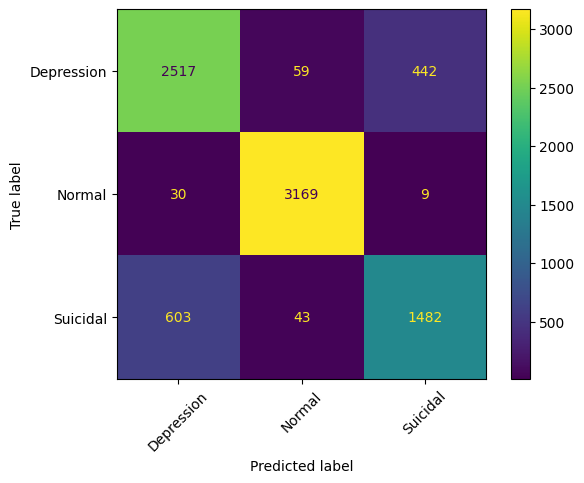

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=sorted(y_test.unique())
)
disp.plot(xticks_rotation=45)

In [17]:
df = pd.Series(
    [
        "I feel so sad and hopeless all the time.",
        "I can't stop thinking about hurting myself.",
        "I'm really anxious about my upcoming exams.",
    ]
)
print(sa.predict(df))

100%|██████████| 1/1 [00:00<00:00, 93.00it/s]

['Depression', 'Normal', 'Normal']
